In [43]:
import numpy as np

from numpy import pi, cos, sin, sqrt, diag
from numpy.linalg import inv
from numpy.random import randn


t = np.linspace(0, 2*pi, 100)
dt = t[1] - t[0]

# position
x = 2*cos(t)
y = sin(2*t)

# velocity
dxdt = -2*sin(t)
dydt = 2*cos(2*t)

# accel
d2xdt2 = -2*cos(t)
d2ydt2 = -4*sin(2*t)

# jerk
d3xdt3 = 2*sin(t)
d3ydt3 = -8*cos(2*t)

In [44]:
# angular speed (scalar)
omega = (dxdt*d2ydt2 - dydt*d2xdt2) / (dxdt**2 + dydt**2)

# speed (scalar)
speed = sqrt(dxdt**2 + dydt**2)

# measurement error
gps_sig = 0.1
omega_sig = 0.3
speed_sig = 0.1

# noisy measurements
x_gps = x + gps_sig * randn(*x.shape)
y_gps = y + gps_sig * randn(*y.shape)
omega_sens = omega + omega_sig * randn(*omega.shape)
speed_sens = speed + speed_sig * randn(*speed.shape)

In [45]:
A = np.array([
    [1, dt, (dt**2)/2, 0, 0, 0],
    [0, 1, dt, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 1, dt, (dt**2)/2],
    [0, 0, 0, 0, 1, dt],
    [0, 0, 0, 0, 0, 1],
    ])

In [46]:
Q1 = np.array([(dt**3)/6, (dt**2)/2, dt, 0, 0, 0])
Q1 = np.expand_dims(Q1, 1)
Q2 = np.array([0, 0, 0, (dt**3)/6, (dt**2)/2, dt])
Q2 = np.expand_dims(Q2, 1)

j_var = max(np.var(d3xdt3), np.var(d3ydt3))
Q = j_var * (Q1 @ Q1.T + Q2 @ Q2.T)

In [47]:
H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0],
    ])

In [48]:
R = diag(np.array([gps_sig**2, gps_sig**2]))

In [49]:
x_init = np.array([x[0], dxdt[0], d2xdt2[0], y[0], dydt[0], d2ydt2[0]])
P_init = 0.01 * np.eye(len(x_init))  # small initial prediction er

In [50]:
# create an observation vector of noisy GPS signals
observations = np.array([x_gps, y_gps]).T

# matrix dimensions
nx = Q.shape[0]
ny = R.shape[0]     
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

# for each time-step...
for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    K[i] = P_pred[i] @ H.T @ inv((H @ P_pred[i] @ H.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - H @ x_pred[i])
    P_est[i] = (Inx - K[i] @ H) @ P_pred[i]

In [51]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/anaconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['beta']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


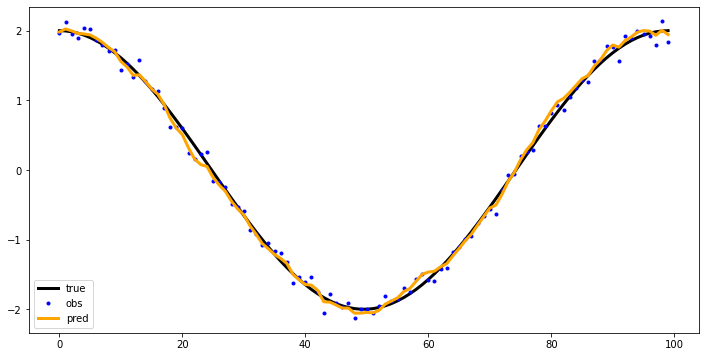

In [52]:
plt.figure(figsize=(12,6))

plt.plot(x, lw=3, color='k', label='true')
plt.plot(x_gps, 'b.', label='obs')
plt.plot(x_est[:, 0], lw=3, color='orange', label='pred')
plt.legend()

In [53]:
def eval_h(x_pred):

    # expand prediction of state vector
    px, vx, ax, py, vy, ay = x_pred

    # compute angular vel
    w = (vx*ay - vy*ax) / (vx**2 + vy**2)

    # compute speed
    s = sqrt(vx**2 + vy**2)

    return np.array([px, py, w, s])

def eval_H(x_pred):

    # expand prediction of state vector
    px, vx, ax, py, vy, ay = x_pred
    V2 = vx**2 + vy**2

    # angular vel partial derivs
    dwdvx = (V2*ay - 2*vx*(vx*ay-vy*ax)) / (V2**2)
    dwdax = -vy / V2
    dwdvy = (-V2*ax - 2*vy*(vx*ay-vy*ax)) / (V2**2)
    dwday = vx / V2

    # speed partial derivs
    dsdvx = vx / sqrt(V2)
    dsdvy = vy / sqrt(V2)

    return np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, dwdvx, dwdax, 0, dwdvy, dwday],
        [0, dsdvx, 0, 0, dsdvy, 0],
        ])


In [54]:
# redefine R to include speedometer and gyro variances
R = diag(np.array([gps_sig**2, gps_sig**2, omega_sig**2, speed_sig**2]))

In [55]:
# create an observation vector of all noisy signals
observations = np.array([x_gps, y_gps, omega_sens, speed_sens]).T

# matrix dimensions
nx = Q.shape[0]
ny = R.shape[0]     
nt = observations.shape[0]

# allocate identity matrix for re-use
Inx = np.eye(nx)

# allocate result matrices
x_pred = np.zeros((nt, nx))      # prediction of state vector
P_pred = np.zeros((nt, nx, nx))  # prediction error covariance matrix
x_est = np.zeros((nt, nx))       # estimation of state vector
P_est = np.zeros((nt, nx, nx))   # estimation error covariance matrix
K = np.zeros((nt, nx, ny))       # Kalman Gain

# set initial prediction
x_pred[0] = x_init
P_pred[0] = P_init

# for each time-step...
for i in range(nt):

    # prediction stage
    if i > 0:
        x_pred[i] = A @ x_est[i-1]
        P_pred[i] = A @ P_est[i-1] @ A.T + Q

    # estimation stage
    y_obs = observations[i]
    y_pred = eval_h(x_pred[i])
    H_pred = eval_H(x_pred[i])
    K[i] = P_pred[i] @ H_pred.T @ inv((H_pred @ P_pred[i] @ H_pred.T) + R)
    x_est[i] = x_pred[i] + K[i] @ (y_obs - y_pred)
    P_est[i] = (Inx - K[i] @ H_pred) @ P_pred[i]

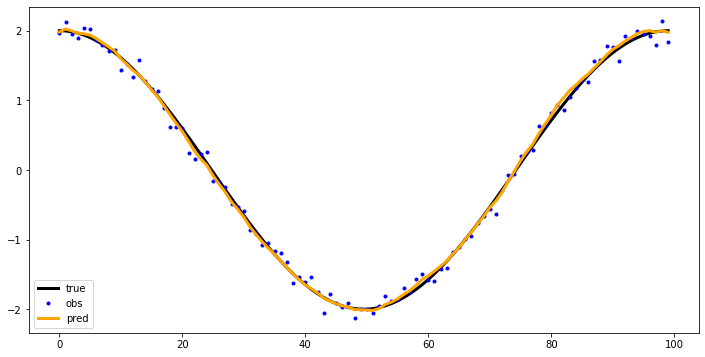

In [56]:
plt.figure(figsize=(12,6))

plt.plot(x, lw=3, color='k', label='true')
plt.plot(x_gps, 'b.', label='obs')
plt.plot(x_est[:, 0], lw=3, color='orange', label='pred')
plt.legend()

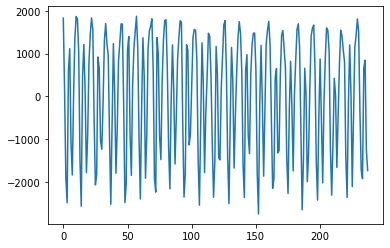

In [65]:
import pandas as pd

ndvi = pd.read_csv('sense_week4/ee-chart.csv')['start0']

plt.plot(ndvi[:400]-np.mean(ndvi[:400]))

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import math

############## Generate data for simulation ##############
# sample parameters (ground truth)
E = 5e3  # Young's modulus (Pa) of the sample
mu = 0.47  # Poisson's ratio of the sample
rho = 1040  # density (kg*m^-3) of the sample
Cs = np.sqrt(E / (2 * (1 + mu) * rho))  # shear wave propagation velocity (m/s) propagating on the sample

# shear wave (excitation) & imaging (detection) parameters used
# to simulate the propagation of a shear wave oscillating at 460 Hz
# where the shear wave vibration was captured by an imaging system
fm = 460  # modulation frequency (Hz)
fs = 10000  # Sampling rate (Hz)
nt = 500  # number of time points
t = np.linspace(0, nt / fs, nt)  # time

sw_lambda = Cs / fm  # shear wave wavelength (m)
r = 4e-3  # propagation radius (m)
phs = 2 * np.pi * r / sw_lambda  # phase change over r (rad)
lateral_scan_range_pix = 400  # lateral scan range (pix)
dphs = phs / lateral_scan_range_pix  # phase change/lateral pixel

# create the space time map (with & without noise)
# the harmonic vibration source was generated at x=0
spacetimemap = []
spacetimemap_w_noise = []
for ix in range(lateral_scan_range_pix):
    dphase = dphs * ix  # phase delay
    harmonic_motion = np.cos(2 * np.pi * fm * t - dphase)  # harmonic motion at one x position
    spacetimemap.append(harmonic_motion)
    wgn = np.random.normal(0, 0.2, np.shape(harmonic_motion))  # additive Gaussian noise
    spacetimemap_w_noise.append(harmonic_motion + wgn)
    
spacetimemap_w_noise[ixoi] = (ndvi[:400]-np.mean(ndvi[:400])).tolist()
fm = 8./365
############## Perform Kalman filter for denoising ##############
# Aim: find state variable x_(k+1) = phi * x_k + w_k, where w_k = noise
# Observed: y_k = H_k * x_k + n_k, where n_k = additive white noise
# Estimation error variance: P_k = E[(x_k-x_k_hat)(x_k-x_k_hat)']
# State estimate update: x_k_hat = x_k_hat_prior + G_k*(y_k - H_k*x_k_hat_prior)

# Here, the measured harmonic vibration signal can be modeled as:
# y_k = beta_k * cos(2*pi*fm*k*T + ph_k) + n_k
# where we want to estimate (1) vibration amplitude (beta_k) & (2) vibration phase (ph_k)
# This can be achived by setting our state variable:
# x_k = [x_k1, x_k2]' = [beta_k*cos(ph_s), beta_k*sin(ph_s)]'
# and H = [cos(2*pi*k*T), -sin(2*pi*k*T)]


# set parameters
T = 1 / fs  # temporal interval
phi = np.eye(2)  # state transition matrix
Q = np.zeros((2, 2))  # uncerntainty in the model = E[w_k * w_k']
n = np.random.normal(0, 0.01, np.shape(t))  # additive white noise
R = np.var(n)  # variance of n (as we only measure single y_k, R=E(n_k * n_k'), dim(R) = 1x1)

# perform Kalman filter at each lateral position
y_est2D = []
Amplitude_median = []
Phase_median = []
for ix in range(lateral_scan_range_pix):
    y = spacetimemap_w_noise[ix]

    # initialization
    P_prior = 1e-1 * np.eye(2)
    x_prior = np.array([[y[0]], [y[1]]])
    xk1 = []  # the cosine component to be estimated
    xk2 = []  # the sine component to be estimated
    y_est = []
    for k in range(len(y)):
        yk = y[k]

        # noise connection between state variables (x_k) & measured signal (y_k)
        H = np.array([[np.cos(2 * np.pi * fm * k * T), -np.sin(2 * np.pi * fm * k * T)]])

        # get Kalman Gain at the k-th step
        S = np.dot(H, np.dot(P_prior, np.transpose(H))) + R
        S_inv = np.linalg.inv(S)
        G = np.dot(np.transpose(P_prior), np.dot(np.transpose(H), S_inv))

        # update the state estimation
        x = x_prior + np.dot(G, (yk - np.dot(H, x_prior)))

        # update the estimation error variance of x_k
        P = np.dot((np.eye(2) - np.dot(G, H)), P_prior)

        # project to k+1
        x = np.dot(phi, x)
        P = np.dot(phi, np.dot(P, np.transpose(phi))) + Q

        # store the state variables values
        x1, x2 = x[0], x[1]
        xk1.append(x1[0])  # x1 = beta * cos(ph)
        xk2.append(x2[0])  # x2 = beta * sin(ph)

        # store the estimated y_k values (obtained from the estimated x_k)
        y_est_temp = np.dot(H, x) + n[k]
        y_est_temp = y_est_temp[0]
        y_est.append(y_est_temp[0])

        P_prior = P
        x_prior = x

    y_est2D.append(y_est)

    # get vibration amplitude from state variables
    beta = np.sqrt(np.power(xk1, 2) + np.power(xk2, 2))
    Amplitude_median.append(np.median(beta))

    # get vibration phase from state variables
    ph = np.arctan(np.divide(xk2, xk1))
    Phase_median.append(np.median(ph))


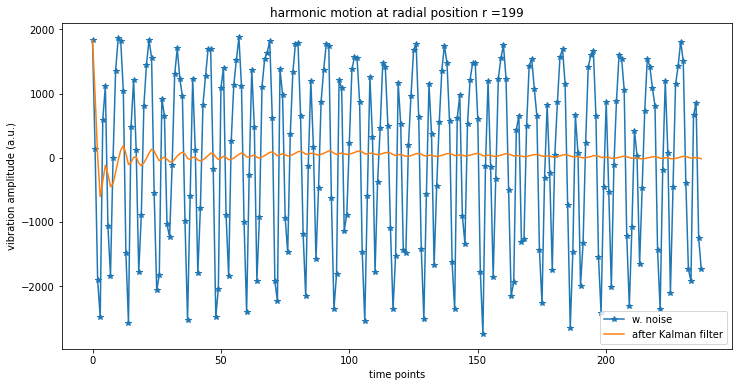

In [105]:
ixoi = 199
plt.figure(figsize=(12,6))
plt.plot(spacetimemap_w_noise[ixoi], '*-')
plt.plot(y_est2D[ixoi])
plt.title('harmonic motion at radial position r =' + str(ixoi))
plt.legend(["w. noise", "after Kalman filter"])
plt.xlabel("time points"), plt.ylabel("vibration amplitude (a.u.)")
plt.show()


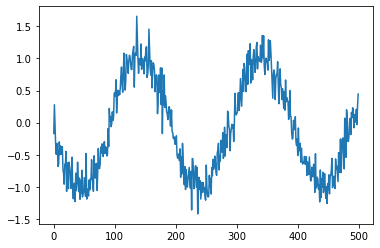

In [84]:
plt.plot(spacetimemap_w_noise[ixoi])
plt.show()

In [118]:
from pykalman import KalmanFilter

ts = ndvi - np.mean(ndvi)
kf = KalmanFilter(em_vars='all')
kf = kf.em(ts)
kf.initial_state_mean = ts[0]
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(ts)


TypeError: only integer scalar arrays can be converted to a scalar index

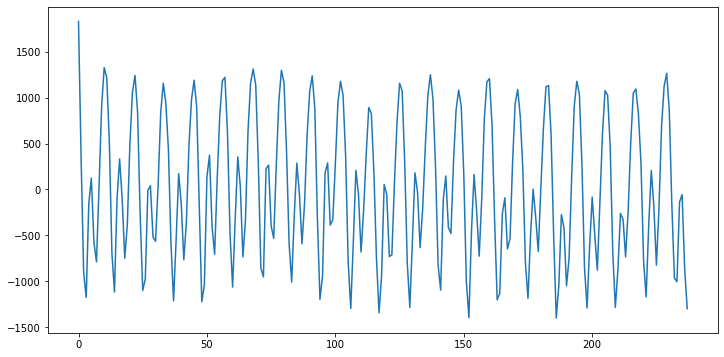

In [138]:
plt.figure(figsize=(12,6))
plt.plot(smoothed_state_means)
plt.fill_between(list(range(smoothed_state_means)), smoothed_state_means-smoothed_state_covariances[:,0,0], smoothed_state_means+smoothed_state_covariances[:,0,0])
plt.plot(ts)

In [129]:
smoothed_state_covariances[:,0,0].shape

(238,)

In [130]:
smoothed_state_means[:,0]-smoothed_state_covariances[:,0,0]

array([[ 1.82773780e+03, -3.30124394e+05, -3.79138626e+05, ...,
        -3.90892217e+05, -4.09726366e+05, -5.37281886e+05],
       [ 3.55214633e+02, -3.31596918e+05, -3.80611149e+05, ...,
        -3.92364740e+05, -4.11198889e+05, -5.38754409e+05],
       [-9.05842434e+02, -3.32857975e+05, -3.81872206e+05, ...,
        -3.93625797e+05, -4.12459946e+05, -5.40015466e+05],
       ...,
       [-5.68333293e+01, -3.32008966e+05, -3.81023197e+05, ...,
        -3.92776788e+05, -4.11610937e+05, -5.39166457e+05],
       [-8.67829534e+02, -3.32819962e+05, -3.81834194e+05, ...,
        -3.93587784e+05, -4.12421933e+05, -5.39977453e+05],
       [-1.29757395e+03, -3.33249706e+05, -3.82263938e+05, ...,
        -3.94017529e+05, -4.12851677e+05, -5.40407197e+05]])

In [134]:
smoothed_state_means[:,0]

array([ 1828.11976069,   355.59659583,  -905.46047145, -1176.02809126,
        -156.52802307,   123.82067733,  -575.2265182 ,  -787.77041563,
          35.72202841,   903.65191171,  1326.30130667,  1216.63215469,
         518.79955178,  -691.77772009, -1115.18375301,  -103.88030905,
         332.47177614,  -100.78374957,  -749.68391424,  -382.34978719,
         493.59676051,  1058.53319685,  1241.89303757,   840.54859035,
        -269.57285115, -1099.57290859,  -974.31116687,    -8.89720054,
          40.27107768,  -517.86465731,  -563.98381865,    52.41869239,
         835.72821789,  1156.83018033,   939.21094447,   436.14945859,
        -583.4475892 , -1212.39184147,  -548.14632319,   170.93582997,
        -158.19530422,  -765.11135796,  -354.62533592,   480.58456675,
         979.12571301,  1189.31665301,   902.57743263,  -163.68641377,
       -1222.11589753, -1037.82995426,   136.48319672,   373.52700486,
        -404.21477796,  -705.59159291,   120.10815615,   809.31513729,
      